# Homework 2: Geostrophy, Thermal Wind, and Sverdrup Transports  #

In this problem set you will apply the concepts of geostrophic balance, thermal wind balance, Ekman and Sverdrup balances to enhance your understanding of the upper ocean circulation

In [22]:
# Basic packages
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import math


# DateTime packages
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
import time
import matplotlib.dates as mdates

# Stats packages
import scipy
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import seaborn as sns
import pyleoclim as pyleo
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Logistical packages
import requests
from importlib import reload
import warnings
warnings.filterwarnings('ignore')

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import matplotlib.path as mpath
import cartopy.feature as cfeature

## 1) Surface Geostrophy and Thermal Wind in Drake Passage

Consider the cartoon shown here which represents a simplified meridional cross section across the Drake Passage in the Southern Ocean (centered at approximately 58°S).
A major simplification is that $\eta$, the sea surface height, and $\sigma_\theta$, the potential density, are assumed to vary _linearly_ in the y direction, and that the geostrophic velocity $u_g$ varies _linearly_ in depth.


<img src="https://github.com/rabernat/intro_to_physical_oceanography/blob/master/book/assignments/figures/drake_passage.png?raw=true" width="400">

### 1a) Assuming a meridional length scale, L, of 850 km and an $\eta_{max}$ of 1 m, estimate the surface geostrophic velocity.  Give the direction of that velocity.

Use the equation for surface geostrophy $u=-\frac{g}{f}\frac{\partial\eta}{\partial y}$

In [6]:
f = gsw.f(-58)
g = 9.8
dn = 1
dy = 850e3
u = -g/f * dn/dy
u = "%.3f" % u
ans = 'Zonal Velocity u = ' + u + ' m/s'
print(ans)
print('Positive zonal velocity is eastward.')

Zonal Velocity u = 0.093 m/s
Positive zonal velocity is eastward.


### 1b) Calculate the effective depth $D$ over which the zonal current falls to zero

...assuming a total transport of 160 Sv. Also assume the following:
- The surface current speed is 0.1 m/s (should be similar to the answer above)
- The current decays linearly with depth until from the surface to $z=-D$
- The current is uniform in the y direction

Note that this part of the problem does not involve geostrophy or anything relating to equations of motion.
It's just a volume transport calculation.

$U  = \int_{z=-D}^{z=0} {u} dz = -\frac{\partial \psi}{\partial y}$

$U  = uD = -\frac{\partial \psi}{\partial y}$



In [411]:
psi = 160e6 # m3/s
dy = 850e3  # m
U = -psi/dy # m2/w
u = 0.1     # m/2
Z = U/u     # m
Z = "%.3f" % Z
ans = 'Effective Depth D = ' + Z + ' m'
print(ans)

Effective Depth D = -1882.353 m


**Unclear why my effective depth of ~1900m is so much smaller than the 3500m given in the next problem.**

### 1c) Use thermal wind to estimate the North-South density difference across the Drake Passage based on the geostrophic shear

Assume:
- The geostrophic shear is uniform over depth $D$ and zero below.
- $D = 3500$ m (should be close to what you got above)

Compare you estimate the the neutral density field from the [WOCE Southern Ocean Atlas Drake Passage section](https://woceatlas.tamu.edu/images/printed/jpg/S1_sig.jpg).
__Is your number reasonable?__

Thermal Wind: $\frac{\partial v}{\partial z} = -\frac{g}{f\rho_0}\frac{\partial \rho}{\partial x}$, $\frac{\partial u}{\partial z} = \frac{g}{f\rho_0}\frac{\partial \rho}{\partial y}$

In [414]:
# Geostrophic velocity varies linearly with depth 
# u (z = 0m) = 0.1
# u (z = -3500m) = 0
u0 = 0.1
u3500 = 0
Z = -3500

# Estimate of vertical shear using known velocities at surface and depth of no motion
# Rough estimate of reference density = 1037 kg/m3
dudz = 0.1/(0 - Z)
f = gsw.f(-58)
g = 9.8
rho0 = 1027

# du/dz * frho0/g = drho/dy
drhody = dudz * (f*rho0)/g
drhody = "%.3e" % drhody
ans = 'Meriodional Density Gradient = ' + drhody + ' kg/m3/m'
print(ans)

Meriodional Density Gradient = -3.703e-07 kg/m3/m


In [85]:
# Based on WOCE
# Density @ 3500m @ 0km
rho1 = 37.15
y1 = 0

# Density @ 3500m @ 800km
rho2 = 36.95
y2 = 800e3

# Estimated Density Gradient from WOCE
drhody_WOCE = (rho1 - rho2)/(y1 - y2)
drhody_WOCE = "%.3e" % drhody_WOCE
ans = 'Meriodional Density Gradient from WOCE = ' + drhody_WOCE + ' kg/m3/m'
print(ans)

Meriodional Density Gradient from WOCE = -2.500e-07 kg/m3/m


**From my calculations, the meridional density gradient is -3.7e-7 kg/m3/m. From WOCE, the meridional density gradient is -2.5e-7 kg/m3/m. My answer potentially overestimates the meridional density gradient, but it is the correct order of magnitude, so it can't be *that* unreasonable.**

## 2) Moving from the cartoon to the real ocean:  Application of the dynamic method
Let's apply the dynamic method procedure we used in class for the North Atlantic region to the Drake Passage from data collected in 2023.  I provide the first few steps of code below, to make sure you can focus on the processes at hand and the interpretation.

**The steps are:**
1. Load the data and find or calculate variables needed (code provided)
2. Map the station locations and potential density section to see what you are working with (code provided)
3. Select stations at ~60°S and 56°S as the end points - your calculation will find the geostrophic shear at the midpoint between them (code provided)
4. Plot the vertical profiles of CT, SA, and sigma_theta (code provided).  __Just looking at these plots, make a prediction about the direction of the shear and its approximate size__
5. Calculate the dynamic height at each endpoint using gsw.geo_strf_dyn_height  (students do this - refer to our in class exercise!)
6. Calculate the geostrophic velocity referenced to 3000 m using gsw.geostrophic_velocity (students do this)
7. Interpret the results! __This is the most important part__.

In [86]:
# load the data
#  The 2023 section
import fsspec
url_hydrosection = "https://cchdo.ucsd.edu/data/38305/FKAD20230131_ctd.nc" #load CTD file since it is more continuous (takes about 30 seconds)
ds = xr.open_dataset(fsspec.open(url_hydrosection).open(), decode_times=False)



In [87]:
# Extract the relevant variables from the dataset and calculate the needed derived variables
P = ds['pressure']  
SA = gsw.SA_from_SP(ds['ctd_salinity'], P, ds['longitude'], ds['latitude'])
CT = gsw.CT_from_t(SA, ds['ctd_temperature'], P)
sigma_theta = gsw.pot_rho_t_exact(SA, ds['ctd_temperature'], P, 0)

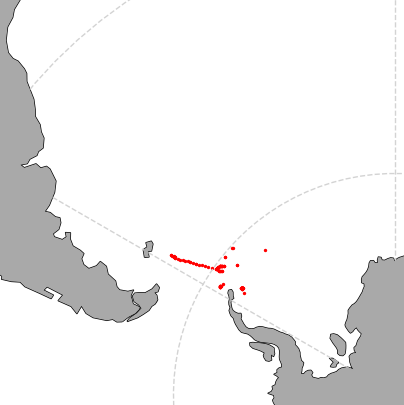

In [88]:
#Plot the station locations just to look where we are in detail
fig, ax = plt.subplots(figsize=[5,5], subplot_kw={'projection':ccrs.SouthPolarStereo()})
crs_plot = ccrs.SouthPolarStereo()
crs_source = ccrs.PlateCarree()
ax.set_extent([-90, 0, -90, -40], crs_source)
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
ax.coastlines()
ax.gridlines()


ax.scatter(ds.longitude,ds.latitude, color = 'red', s = 2, transform=crs_source)

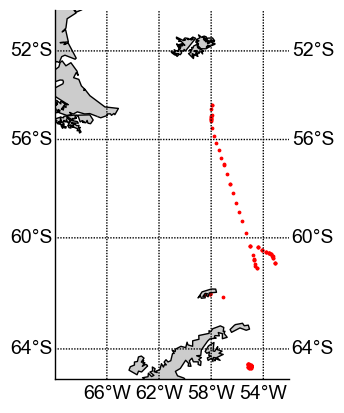

In [89]:
#Plot the station locations just to look where we are in detail
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

#I make a nice map below with continents, but if you don't have the right packages, plt.scatter(ds.longitude,ds.latitude) will work fine!
# setup mercator map projection.
m = Basemap(llcrnrlon=-70.,llcrnrlat=-65.,urcrnrlon=-52.,urcrnrlat=-50.,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',projection='merc')#,\
            #lat_0=-66.,lon_0=-66.,lat_ts=20.)
x, y = m(ds.longitude,ds.latitude)
m.scatter(x,y,3,marker='o',color='r')
m.drawcoastlines()
m.fillcontinents()
# draw parallels
m.drawparallels(np.arange(-68,-42,4),labels=[1,1,0,1]);
# draw meridians
m.drawmeridians(np.arange(-66,-50,4),labels=[1,1,0,1]);

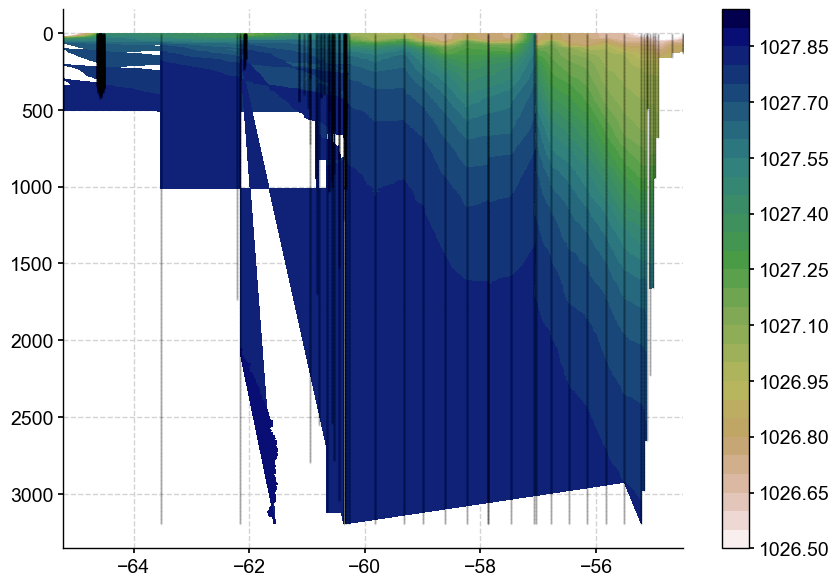

In [104]:
# Plot the section
fig, ax = plt.subplots(figsize = [10,7])
P_grid, latitude_grid,= np.meshgrid( P[30,:],ds.latitude)
contour_levels = np.arange(1026.5, 1028, 0.05)
im = ax.contourf(latitude_grid, P_grid, sigma_theta, levels=contour_levels,cmap="gist_earth_r")
plt.colorbar(im, ax = ax)
ax.invert_yaxis()

# Plot black dots where P is a number (e.g., P != 0)
# Use np.where to get the positions where P meets the condition
x_positions, y_positions = np.where(P != 0)

# Find positions where P is not NaN
valid_positions = np.logical_not(np.isnan(P))

# Extract the longitude and P values where P is valid
x_positions = latitude_grid[valid_positions]  # Latitude for valid x-axis positions
y_positions = P_grid[valid_positions]          # P for valid y-axis positions


# Overlay the black dots on top of the pcolormesh plot
plt.scatter(x_positions, y_positions, color='black', s=0.1, zorder=3, alpha = 0.1)


In [225]:
# pick the stations at approximately 60°S and 56°S (I found them by trial and error)
#
Slat = ds['latitude'].values[30]  
Nlat = ds['latitude'].values[13]  
Slon = ds['longitude'].values[30]
Nlon = ds['longitude'].values[13]
Slat, Nlat, Slon, Nlon, 

(-60.36522, -56.15004, -54.40724, -57.61428)

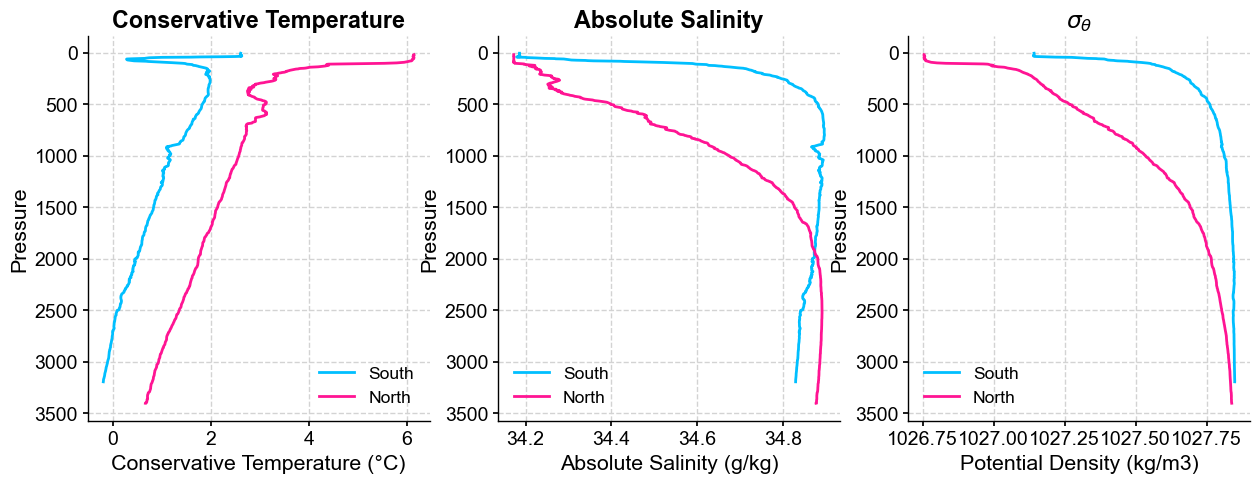

In [125]:
fig, axarr = plt.subplots(ncols = 3, figsize = [15,5])
axarr = axarr.flatten()

data = [CT, SA, sigma_theta]
xlab = ['Conservative Temperature (°C)', 'Absolute Salinity (g/kg)', 'Potential Density (kg/m3)']
tlt = ['Conservative Temperature', 'Absolute Salinity', r'$\sigma_{\theta}$' ]

for i,ax in enumerate(axarr):
    ax.invert_yaxis()
    XS = data[i][30,:]
    YS = P[30,:]
    XN = data[i][13,:]
    YN = P[13,:]
    ax.plot(XS,YS, color = 'deepskyblue', label = 'South')
    ax.plot(XN,YN, color = 'deeppink', label = 'North')
    ax.set_xlabel(xlab[i])
    ax.set_title(tlt[i], fontweight = 'bold')
    ax.set_ylabel('Pressure')
    ax.legend()
    

## 2.1 From the plots you've made so far, predict the direction of the zonal velocity at 1500 m, relative to the (unknown) velocity at a pressure of 3000 dbar and its order-of-magnitude size.
If the velocity at a pressure of 3000 dbar were zero (i.e. "the level of no motion" was at 3000 dbar) what would the approximate velocity be at the surface?  How does it compare to the calcuation from the cartoon in Question 1?

Thermal Wind: 

$\frac{\partial v}{\partial z} = -\frac{g}{f\rho_0}\frac{\partial \rho}{\partial x}$

$\frac{\partial u}{\partial z} = \frac{g}{f\rho_0}\frac{\partial \rho}{\partial y}$

$\int_{u(z=3000m) = 0}^{u(1500m) = u}\partial u = \frac{g}{f\rho_0}\frac{\partial \rho}{\partial y} \int_{Z = 3000}^{Z = 1500}\partial z$

$u_{1500} - 0 = \frac{g}{f\rho_0}\frac{\partial \rho}{\partial y} (1500 - 3000)$

The relationship between depth and pressure here is about one on one

In [318]:
# Difference in potential densities between north and south 
sigma_north = sigma_theta[13,:]
sigma_south = sigma_theta[30,:]

# Convert from P to Z
Znorth = gsw.z_from_p(P[13,:],ds['latitude'].values[13])
Zsouth = gsw.z_from_p(P[30,:],ds['latitude'].values[30])

# Domain length
dy = 800e3

# ∆Density: I just took the average diff of densities between the two profiles
dsigma = (sigma_north - sigma_south).mean().values 
DSIGMA = "%.3f" % dsigma
ans = '∆Density = ' + DSIGMA + ' kg/m3'
print(ans)

# Constants
g = 9.8
f = gsw.f(-57)
rho0 = np.nanmean([sigma_north,sigma_south])

# Depth levels for 1500dbar and 3000dbar
Z1500 = Znorth[750]
Z3000 = Znorth[1498]

# Assumed depth of no motion
u3000 = 0

# Calculate velocity
u1500 = g/(f*rho0) * dsigma/dy * (Z1500 - Z3000) + u3000
u0 = g/(f*rho0) * dsigma/dy * (0 - Z3000) + u3000

U1500 = "%.4f" % u1500
ans = 'Zonal velocity @ 1500dbar = ' + U1500 + ' m/s'
print(ans)

U0 = "%.4f" % u0
ans = 'Zonal velocity @ surface = ' + U0 + ' m/s'
print(ans)

∆Density = -0.202 kg/m3
Zonal velocity @ 1500dbar = 0.0288 m/s
Zonal velocity @ surface = 0.0583 m/s


The zonal velocity calculated here is smaller that what I calculated in Question 1, but it is the same order of magnitude as my previous answer but an order of magnitude less than the expected "true" answer?. Also, positive velocity is eastward.

## 2.2 Calculate the dynamic height for the southern and northern stations and provide a plot of dynamic height versus pressure

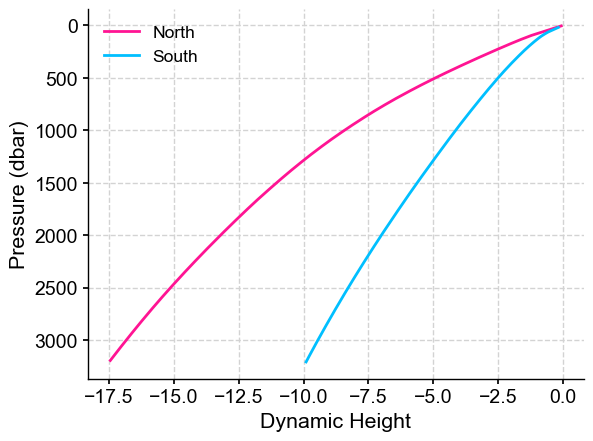

In [132]:
# Calculate the dynamic height for the western and eastern stations
CTnorth = CT[13,:]
CTsouth = CT[30,:]
SAnorth = SA[13,:]
SAsouth = SA[30,:]
Pnorth = P[30,:]
Psouth = P[13,:]
dyn_height_N = gsw.geo_strf_dyn_height(SAnorth, CTnorth, Pnorth, 0)
dyn_height_S= gsw.geo_strf_dyn_height(SAsouth, CTsouth, Psouth, 0)

# Plot dynamic height
fig, ax = plt.subplots()
ax.plot(dyn_height_N, Pnorth, color = 'deeppink',label = 'North')
plt.plot(dyn_height_S, Psouth, color = 'deepskyblue', label = 'South')
ax.invert_yaxis()
ax.set_xlabel('Dynamic Height')
ax.set_ylabel('Pressure (dbar)')
ax.legend()

## 2.3 Calculate the geostrophic velocity at the sea surface relative to 3000 dbar and give the answer in m/s

In [445]:
X = 3000   # depth of no motion
dhN_0 = np.interp(X, P[30,~np.isnan(dyn_height_N)], dyn_height_N[~np.isnan(dyn_height_N)])
dhS_0 = np.interp(X, P[13,~np.isnan(dyn_height_S)], dyn_height_S[~np.isnan(dyn_height_S)])

geostrophic_velocity, mid_lat, mid_long = gsw.geostrophic_velocity(
    [dhS_0, dhN_0], [Slon, Nlon], [Slat, Nlat], X)

geostrophic_velocity = "%.4f" % geostrophic_velocity
ans = 'Zonal velocity @ surface = ' + geostrophic_velocity + ' m/s'
print(ans)

Zonal velocity @ surface = 0.1181 m/s


## 2.4 Interpret what you found here. 
* What is the velocity at the sea surface? **0.1181 m/s**
* How close was your eye-ball estimate in question 2.1 from the final answer? **My eyeball estimate was about half of the "true" answer.**
* If there were a slowdown in the Drake Passage geostrophic transport, how would you predict that it manifest in the density field? **I think the density difference between the north and the south would be less.**

## 3) Sverdrup Transport
Use the wind curl map here and concepts from Sverdrup balance to answer the following questions:
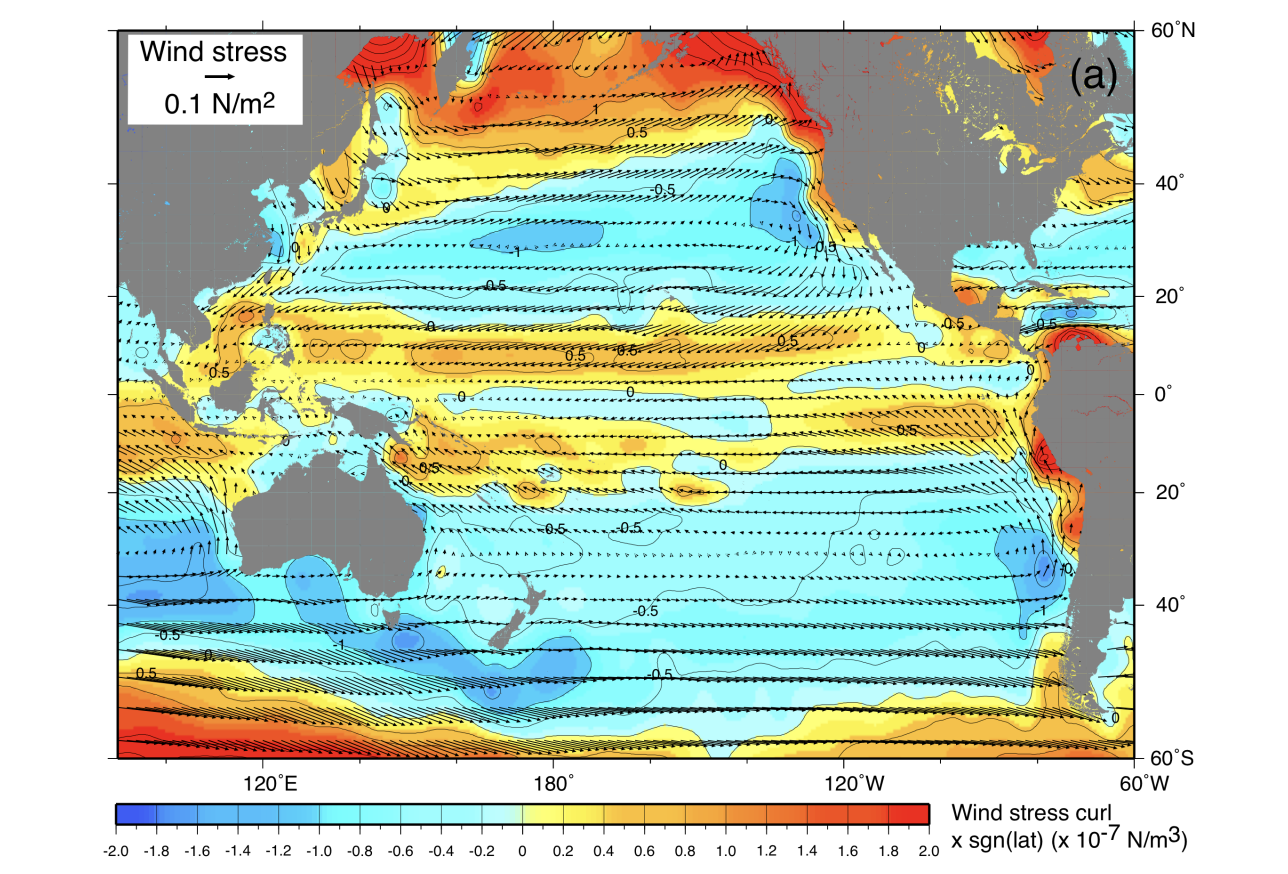


### 3.1 What is the Ekman pumping velocity in the center of the Pacific?  Give the direction and approximate size.

$$
w_{Ekman} = \frac{1}{\rho_0 f} (\frac{\partial \tau_y}{\partial x} - \frac{\partial \tau_x}{\partial y})
$$

Here's a figure from the [Abernathy text](http://rabernat.github.io/intro_to_physical_oceanography/vorticity_sverdrup_transport_and_gyres.html) for reference.
<img src="http://rabernat.github.io/intro_to_physical_oceanography/_images/07_ekman_17_1.png" width="600">

In [322]:
# Wind stress curl corresponds to the colormap
# In the NP Subtrop Gyre, wind stress curl is about |0.75e-7| N/m3
# but negative
tau_curl = -0.75e-7
rho0 = 1027
f = gsw.f(30)
s_in_year = 3.154e7

w_m_s = 1/(rho0*f)*tau_curl
w_m_yr = w_m_s*s_in_year

w = "%.4f" % w_m_yr
ans = 'Ekman pumping velocity = ' + w + ' m/yr'
print(ans)

Ekman pumping velocity = -31.5863 m/yr


The Ekman pumping velocity I got is comparable to what was in the Abernathy textbook.

### 3.2 Estimate the Sverdrup transprt in the center of the gyre



$$
\beta V_{Sv} = \frac{1}{\rho_0} \text{curl}(\vec{\tau_{surf}})
$$

Low key, I did copy this snippet of code directly from the [Abernathy text](http://rabernat.github.io/intro_to_physical_oceanography/vorticity_sverdrup_transport_and_gyres.html), so thanks Ryan.

In [426]:
omega = 7.29e-5
R = 6.3781e6
f = gsw.f(30)
beta = 2 * omega / R * np.cos(np.deg2rad(30))
rho0 = 1027
V_Sv = tau_curl / (beta * rho0)

VSv = "%.4f" % V_Sv
ans = 'Sverdrup Transport (Depth-Integrated Velocity) = ' + VSv + ' m2/s'
print(ans)

Sverdrup Transport (Depth-Integrated Velocity) = -3.6889 m2/s


Just to check this against the figure from the [Abernathy text](http://rabernat.github.io/intro_to_physical_oceanography/vorticity_sverdrup_transport_and_gyres.html), Ryan got a Sverdrup transport in the Pacific of about -2 to -3 m$^2$/s, so my estimate of -3.7 m$^2$/s is a bit high but within reason.
<img src="http://rabernat.github.io/intro_to_physical_oceanography/_images/vorticity_sverdrup_transport_and_gyres_11_1.png" width="600">

### 3.3 Assuming this Sverdrup transport is uniform across 9000 km of Pacific Ocean interior, estimate the total transport in Sverdrups.

$$
\int_{0m}^{9000e3 m} V_{Sv} dr = \Psi(9000e3) - \Psi(0) = V_{Sv} * 9000e3 - V_{Sv} * 0
$$

In [427]:
Psi_SV = (V_Sv * 9000e3)/1e6

PSI = "%.4f" % Psi_SV
ans = 'Sverdrup Transport = ' + PSI + ' Sv'
print(ans)

Sverdrup Transport = -33.1999 Sv


To verify that any of this is reasonable, I am using an adaptation of some MATLAB code I have from an undergrad class that calculates the streamfunction. It is different in that it requires some distance in the y-direction which I have set to be 1000 km. I got a similar answer, so my previous can't be *that* bad (though it can still be pretty bad because it is quite sensitive to the y-distance). And by similar answer, I mean the average of this calculation is similar to the previous. But a simple average is probably not an amazing estimate; ideally the average would be weighted somehow.

If you are wondering exactly how I got this calculation/code, I honestly can't tell you. My notes from undergrad are a mess, and the problem I was answering for it (from my junior year physical oceanography class) had a lot of complexities, including some need to convert between latitude and longitude to distance. I also have a sister code that calculates a similar transport for the western boundary that is objectivey incorrect (because it gives a volume transport of like 1e12 Sv).

Sverdrup Transport = -32.5247 Sv


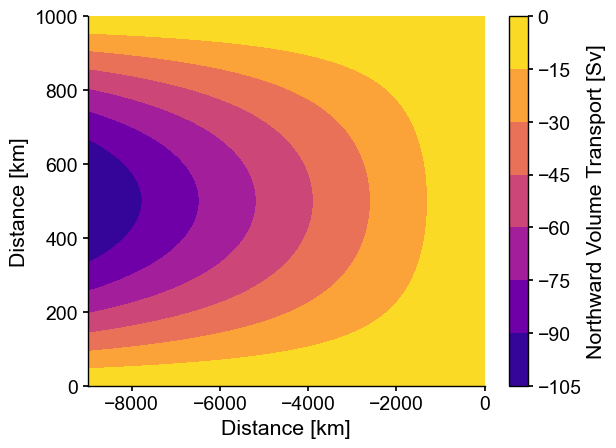

In [438]:
Ly = 1000e3
Lx = 9000e3
x1 = np.linspace(-Lx,0)
y1 = np.linspace(0, Ly)
[x,y] = np.meshgrid(x1, y1)
psi = (-1/(rho0*beta))* tau_curl/(Ly) * np.pi * x * np.sin((np.pi * y)/Ly)

fig, ax = plt.subplots()
im = ax.contourf(x/1e3,y/1e3,psi, cmap = 'plasma')
cbar = plt.colorbar(im, ax = ax)
cbar.set_label('Northward Volume Transport [Sv]')
ax.set_xlabel('Distance [km]')
ax.set_ylabel('Distance [km]')
psi.mean()

PSI = "%.4f" % psi.mean()
ans = 'Sverdrup Transport = ' + PSI + ' Sv'
print(ans)

If I increase the y-distance to 2200km, the result actually looks pretty similar to what Ryan calculated in the [Abernathy text](http://rabernat.github.io/intro_to_physical_oceanography/vorticity_sverdrup_transport_and_gyres.html). Why 2200km? Because it seems the gyre stretches over 20°N to 40°N. With 1° latitude equally 111 km, that's 2220km, and 2200km is close enough.

<img src="http://rabernat.github.io/intro_to_physical_oceanography/_images/vorticity_sverdrup_transport_and_gyres_17_1.png" width="600">


Sverdrup Transport = -14.7840 Sv


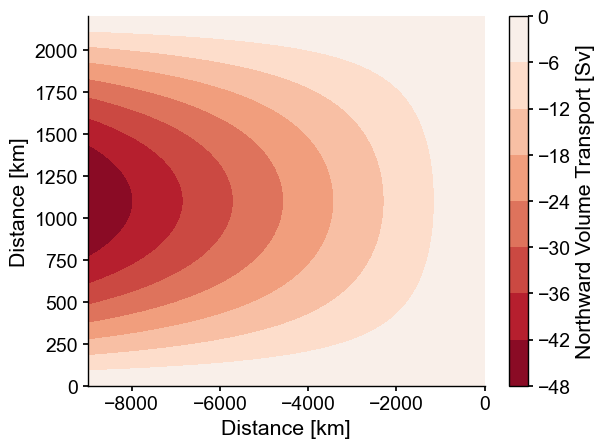

In [443]:
Ly = 2200e3
Lx = 9000e3
x1 = np.linspace(-Lx,0)
y1 = np.linspace(0, Ly)
[x,y] = np.meshgrid(x1, y1)
psi = (-1/(rho0*beta))* tau_curl/(Ly) * np.pi * x * np.sin((np.pi * y)/Ly)

fig, ax = plt.subplots()
im = ax.contourf(x/1e3,y/1e3,psi, cmap = 'RdBu', vmin = -50, vmax = 50)
cbar = plt.colorbar(im, ax = ax)
cbar.set_label('Northward Volume Transport [Sv]')
ax.set_xlabel('Distance [km]')
ax.set_ylabel('Distance [km]')
psi.mean()

PSI = "%.4f" % psi.mean()
ans = 'Sverdrup Transport = ' + PSI + ' Sv'
print(ans)

### 3.4 Knowing the width of the Kuroshio is about 100 km, and making the (not great) assumption that flow is uniform over that distance, estimate the speed of the Kuroshio.

Unsure this is the correct approach but it's the one I'm taking. Volume flow from Sverdrup must be balanced by the volume flow from the western boundary current.

$$
\Psi_{Sv} = V_{Sv}*L_{Pacific} = -\Psi_{WB} = V_{WB}*L_{Kuroshio}
$$

I also did a quick [Wikipedia look-up of the Kuroshio](https://en.wikipedia.org/wiki/Kuroshio_Current) and [some other internet sleuthing](https://www.earthdata.nasa.gov/news/feature-articles/probing-black-current) just to get a bit of info that can help me sanity-check my answers. Apparently, the volume transport of the Kuroshio is ~25 Sv, which is somewhat similar in magnitude to the Sverdrup volume transport I have already calculated. So the assumption that $\Psi_{Sv} = -\Psi_{WB}$ seems ok. Further, the speed of the Kuroshio is supposedly 2.5 m/s, and the depth of the Kuroshio is as much as 1000m. It's likely not that deep everywhere, though.

In [434]:
LPacific = 9000e3
Psi_Sv = (V_Sv * LPacific)  # m3/s
Psi_WB = -Psi_Sv  # m3/s
Lkuroshio = 100e3 # m
V_WB = Psi_WB/Lkuroshio  # m2/s

VWB = "%.4f" % V_WB
ans = 'Western Boundary Depth-Integrated Velocity (positive north) = ' + VWB + ' m2/s'
print(ans)

Western Boundary Depth-Integrated Velocity (positive north) = 331.9988 m2/s


Since 332 m<sup>2</sup>/s seems awfully large, as a sanity check, let's assume the average depth over the Kuroshio is between 100m and 500m. Dividing by this depth range will give up a range of velocities in the slightly more familiar units of m/s. Those depths give us velocities that fall within the range I saw online (which is about 0.5-3 m/s).

In [433]:
Zkuroshio = [100,500]
v_wb = V_WB / Zkuroshio

vmin = "%.4f" % v_wb[0]
ans = 'Kuroshio Velocity assuming 100m depth = ' + vmin + ' m/s'
print(ans)

vmax = "%.4f" % v_wb[1]
ans = 'Kuroshio Velocity assuming 500m depth = ' + vmax + ' m/s'
print(ans)

Kuroshio Velocity assuming 100m depth = 3.3200 m/s
Kuroshio Velocity assuming 500m depth = 0.6640 m/s
